# Prediciendo precios de casas de Ames: flujo de trabajo secuencial
**Autor**: [Alberto Bas](https://www.github.com/albertobas)<br />**Fecha de publicación**: 01/03/2022<br />**Descripción**: regresión de precios en el conjunto de datos _Ames housing prices_

<a title="Open in Colab" href="https://colab.research.google.com/github/albertobas/ames-housing-prices/blob/main/precios_casas_ames_modelos.ipynb"><img alt="Open in Colab badge" align="left" width="117" height="20" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>
<br />
___

El propósito de este cuaderno es realizar un análisis de aprendizaje supervisado en el que se modela para predecir un valor continuo -utilizando el conjunto de datos de Ames Housing Prices- mediante la regresión del precio de venta de una casa a diferentes medidas y calificaciones. Luego, se aprovechan los precios históricos que actúan como variables de respuesta para supervisar el proceso de aprendizaje de este modelo.

Para realizar esta tarea de regresión se han desarrollado pipelines -objetos transformadores y estimadores encadenados que conforman un flujo de trabajo- y un conjunto de pipelines. A cada pipeline se le da la misma entrada, sin embargo, los estimadores obtienen diferentes conjuntos de datos según los objetos de preprocesamiento (transformadores en scikit-learn) que asignamos a cada pipeline.

La idea es evaluar no solo el objeto regresor, sino todas las pipelines mediante validación cruzada para obtener parámetros optimizados para los regresores. Por lo tanto, todo el preprocesamiento a través de objetos -escalado y / o valores imputados con promedios- se realizará para cada lote de datos durante el proceso de evaluación para evitar el uso de información de todo el conjunto en cada etapa de validación, que sería -en cierta medida- sesgar los resultados.


## Configuración

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import xgboost as xgb
from dask.distributed import Client
from IPython.display import display
from scipy.stats import boxcox, kurtosis, norm, skew
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.svm import SVR
from utils import Get_Categorical, Get_Dummies, HousePrices_AvgFeat, HousePrices_BoxCox, Imputer, rmse, rmse_cv, BoostingTunerCV, PipeTunerCV, Weighted_Average
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

%matplotlib inline
pd.set_option('display.max_columns', 200)

## Preprocesamiento de datos

En esta sección se explica cómo se realiza el preprocesamiento de los datos antes de pasarlos a las pipelines. Todas las clases que utilizo en las pipelines para preprocesar los datos se pueden encontrar [aquí](utils/preprocessing.py 'Clases para preprocesamiento').

In [2]:
X_train = fetch_openml(name="house_prices", as_frame=True, data_home='data')['frame']
y_train = X_train['SalePrice']
X_train.drop(['Id'], axis=1, inplace=True)
verbal = [f for f in X_train.columns if X_train.dtypes[f] == 'object']
numerical = [f for f in X_train.columns if X_train.dtypes[f] != 'object']
qualitative = verbal + ['MSSubClass', 'OverallQual', 'OverallCond']
quantitative = [n for n in numerical if n not in qualitative and n != 'SalePrice']

### Datos faltantes

Como parte del flujo de trabajo, la imputación de los valores faltantes dentro de la cadena en cada pipeline la dará un objeto `Imputer`. Sin embargo, la mayoría de los valores faltantes son deducibles simplemente considerando otros valores en la misma observación:

- En el caso de las variables cualitativas, considere el siguiente ejemplo, si una observación mostrase que no hay piscina, es decir, `PoolArea` fuese cero, entonces asignaríamos `NA` a la observación pertinente en `PoolQC`, y es que la descripción de los datos indica que este es el valor de la variable de calidad de la piscina cuando en una casa no hay piscina. Y si de hecho hubiese una piscina, introduciríamos `None` para no sesgar el resultado. También, en relación con las pipelines que utilizan conjuntos con variables dummy -o indicadoras-, cuando los indicadores se crean, esta observación no será representada por ninguna de las clases `PoolQC`, y en relación con las pipelines que utilizan conjuntos categóricos, `None` no formaría parte de las categorías.

- En el caso de variables cuantitativas, y siguiendo un ejemplo similar, si faltase un valor en `GarageArea` para una observación determinada y `GarageQual` fuese `NA` en la misma fila, entonces se imputaría `0` en `GarageArea`.

El resto de los valores faltantes serán asignados por un objeto `Imputer`, el cual toma como uno de los argumentos un número para completar los valores faltantes, o el tipo de promedio (media o mediana). Este promedio también se puede calcular después de agrupar en base a otro predictor, pasando el nombre de la variable al argumento _groupby_.

In [3]:
# Missing values in the dataset
missing = X_train.apply(lambda x: sum(x.isnull()),axis=0).sort_values(ascending=False)
percent = np.round((X_train.apply(lambda x: sum(x.isnull()),axis=0)/
                    X_train.apply(lambda x: len(x.isnull()),axis=0)*100), 2).sort_values(ascending=False)
train_missing = pd.concat([missing, percent], axis=1, keys=['Missing', '%']).head(20)
train_missing.columns.name = "Training Set"
display(train_missing.transpose())

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageYrBlt,GarageCond,GarageType,GarageFinish,GarageQual,BsmtExposure,BsmtFinType2,BsmtCond,BsmtQual,BsmtFinType1,MasVnrArea,MasVnrType,Electrical,MSSubClass
Training Set,,,,,,,,,,,,,,,,,,,,
Missing,1453.00,1406.0,1369.00,1179.00,690.00,259.00,81.00,81.00,81.00,81.00,81.00,38.0,38.0,37.00,37.00,37.00,8.00,8.00,1.00,0.0
%,99.52,96.3,93.77,80.75,47.26,17.74,5.55,5.55,5.55,5.55,5.55,2.6,2.6,2.53,2.53,2.53,0.55,0.55,0.07,0.0


In [4]:
for column in qualitative:
    if column in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
        X_train[column] = X_train[column].fillna(pd.Series(np.where(X_train['TotalBsmtSF']==0, 'NA', None)))
    elif column == 'FireplaceQu':
        X_train[column] = X_train[column].fillna(pd.Series(np.where(X_train['Fireplaces']==0, 'NA', None)))
    elif column in ['GarageCond', 'GarageFinish', 'GarageQual', 'GarageType']:
        X_train[column] = X_train[column].fillna(pd.Series(np.where(X_train['GarageArea']==0, 'NA', None)))
    elif column == 'KitchenQual':
        X_train[column] = X_train[column].fillna(pd.Series(np.where(X_train['KitchenAbvGr']==0, 'NA', None)))
    elif column == 'MasVnrType':
        X_train[column] = X_train[column].fillna(pd.Series(np.where(X_train['MasVnrArea']==0, 'None', None)))
    elif column == 'MiscFeature':
        X_train[column] = X_train[column].fillna(pd.Series(np.where(X_train['MiscVal']==0, 'NA', None)))
    elif column == 'PoolQC':
        X_train[column] = X_train[column].fillna(pd.Series(np.where(X_train['PoolArea']==0, 'NA', None)))
    elif column in ['Exterior1st', 'Exterior2nd']:
        X_train[column] = X_train[column].fillna('Missing')
    # Utilities does not add info, all its values in the training set but one observation are the same
    elif column == 'Utilities':
        X_train.drop(column, axis=1, inplace=True)

for column in quantitative:
    if column in ['BsmtFullBath', 'BsmtFinSF2', 'BsmtFinSF1', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF']:
        X_train[column] = X_train[column].fillna(pd.Series(np.where((X_train['BsmtQual']=='NA') | 
                                                                (X_train['BsmtCond']=='NA') | 
                                                                (X_train['BsmtExposure']=='NA') | 
                                                                (X_train['BsmtFinType1']=='NA') | 
                                                                (X_train['BsmtFinType2']=='NA'), 0, None)))
    elif column in ['GarageArea', 'GarageCars', 'GarageYrBlt']:
        X_train[column] = X_train[column].fillna(pd.Series(np.where((X_train['GarageCond']=='NA') | 
                                                                (X_train['GarageFinish']=='NA') | 
                                                                (X_train['GarageQual']=='NA') | 
                                                                (X_train['GarageType']=='NA'), 0, None)))       
    elif column == 'MasVnrArea':
        X_train[column] = X_train[column].fillna(pd.Series(np.where(X_train['MasVnrType']=='None', 0, None))) 

for column in ['MSSubClass', 'OverallQual', 'OverallCond', 'GarageYrBlt', 'YearBuilt', 
            'YearRemodAdd', 'YrSold', 'MoSold']:
    X_train[column] = X_train[column].astype('int')

### Outliers

El conjunto de entrenamiento contiene algunas observaciones con valores poco comunes en algunos de sus espacios de predicción y también en su respuesta. Los efectos de estas observaciones podrían invalidar el ajuste si las introdujéramos en el modelo de aprendizaje.

Por otro lado, eliminarlos podría evitar que el estimador aprenda algunas peculiaridades de los datos y, al final, generalice mejor.

Opté por no eliminar ninguna observación del conjunto, por transformar algunas variables, así como por crear otras para intentar paliar el impacto de estos valores atípicos sobre el ajuste resultante.

En la figura siguiente vemos cuatro de los predictores con algunos puntos que, en diferente medida, no siguen la tendencia general de los datos, o tienen valores que no son comunes en el espacio del predictor:

In [5]:
colors = plt.rcParams["axes.prop_cycle"]()

In [6]:
plt.rcParams.update({'font.size': 22}) # must set in top

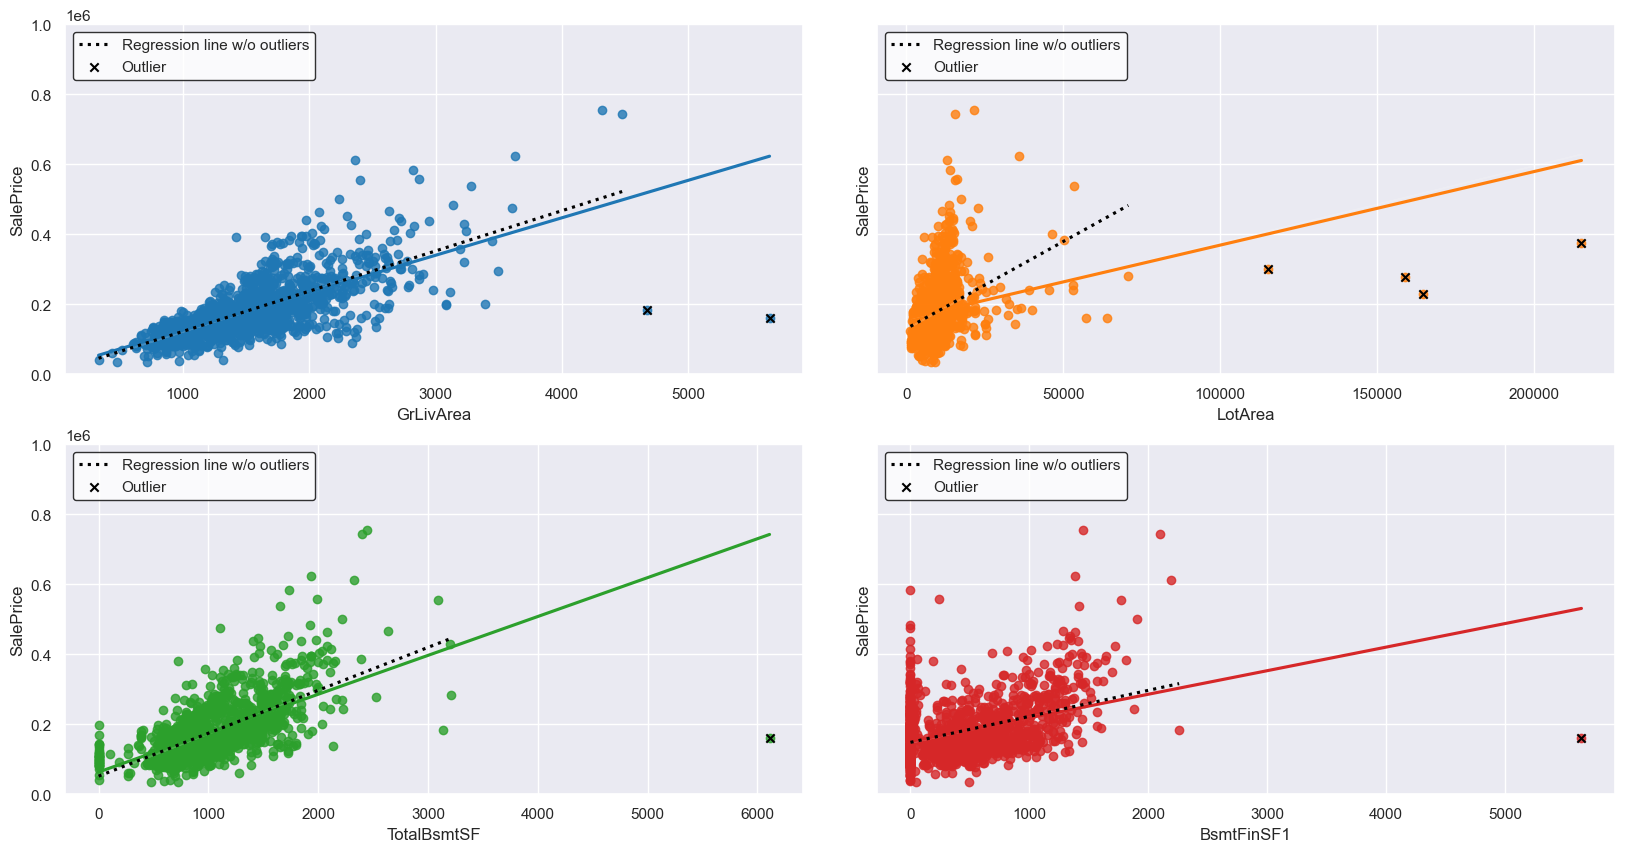

In [7]:
plt.rcParams.update({'font.size': 42}) # must set in top
sns.set(font_scale=1)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10), sharex=False, sharey=True)
fig.subplots_adjust(hspace=.2, wspace=.1)
outliers_arr = np.array([[X_train['GrLivArea']>4500, X_train['LotArea']>100000], 
                         [X_train['TotalBsmtSF']>4000, X_train['BsmtFinSF1']>3000]])
predictors_w_outliers_arr = np.array([['GrLivArea', 'LotArea'], ['TotalBsmtSF', 'BsmtFinSF1']])
for irow in range(2):
    for icol in range(2):
        c = next(colors)["color"]
        sns.regplot(x=X_train[predictors_w_outliers_arr[irow][icol]], y=X_train['SalePrice'], ax=ax[irow][icol], 
                    ci=0, color=c)
        sns.regplot(x=X_train.loc[np.invert(outliers_arr[irow][icol])][predictors_w_outliers_arr[irow][icol]], 
                    y=X_train.loc[np.invert(outliers_arr[irow][icol])]['SalePrice'], ax=ax[irow][icol], 
                    color='black', ci=0, 
                    scatter=False, line_kws={'ls': 'dotted'}, label='Regression line w/o outliers')
        ax[irow][icol].scatter(X_train.loc[outliers_arr[irow][icol]][predictors_w_outliers_arr[irow][icol]], 
                               X_train.loc[outliers_arr[irow][icol]]['SalePrice'], c='black', label='Outlier', 
                               marker = 'x')
        ax[irow][icol].legend(edgecolor='black', loc=2, facecolor='white', frameon=True)
        ax[irow][icol].set_ylim([0, 1000000])

Podemos ver gráficamente el impacto de algunos puntos en el ajuste de regresión y cómo cambia cada ajuste simplemente eliminando una observación o algunas de ellas.

Entonces, tomemos dos de estas variables que creemos que contienen valores atípicos y transformémoslas. En el caso de `GrLivArea` y `LotArea`, podemos ver el resultado de transformar tanto el predictor como la respuesta a continuación:

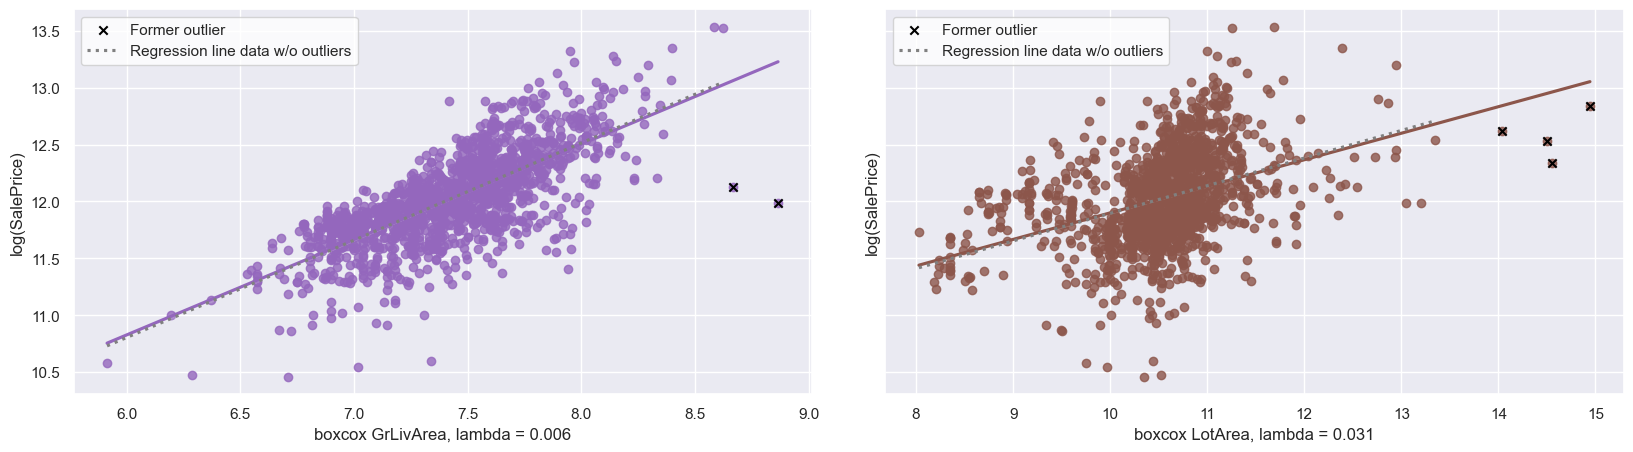

In [8]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,5), sharey=True)
fig.subplots_adjust(wspace=.1)
for i, (feat, lambd) in enumerate([('GrLivArea', 0.006), ('LotArea', 0.031)]):
    c = next(colors)["color"]
    sns.regplot(x=boxcox(X_train[feat], lmbda=lambd), y=np.log(X_train['SalePrice']), ax=ax[i], ci=0, color=c);
    ax[i].scatter(boxcox(X_train[outliers_arr[0][i]][feat], lmbda=lambd), 
                  np.log(X_train[outliers_arr[0][i]]['SalePrice']), 
                  c='black', marker='x', label='Former outlier')
    sns.regplot(x=boxcox(X_train[np.invert(outliers_arr[0][i])][feat], lmbda=lambd), 
                y=np.log(X_train[np.invert(outliers_arr[0][i])]['SalePrice']), color='gray', ci=0, 
                label='Regression line data w/o outliers', scatter=False, line_kws={'ls': 'dotted'}, 
                ax=ax[i])
    ax[i].legend(loc='best', facecolor='white', frameon=True)
    ax[i].set_xlabel("boxcox {}, lambda = {}".format(feat, lambd))
    ax[i].set_ylabel('log(SalePrice)')

La presencia de las mismas observaciones que estaban alterando la regresión antes ahora prácticamente no afecta el ajuste resultante. Los puntos que estaban fuera de la tendencia general de los datos ahora lo siguen y los puntos con valores en el espacio del predictor que eran demasiado grandes en comparación con el resto de las observaciones ahora tienen valores similares gracias al cambio de escala después de usar una transformación Box Cox y logarítmica.

### Creación de variables
Hay algunos otros aspectos que pueden influir en el precio de una casa, he creado nuevas variables a partir de las variables que ya tenemos para intentar capturar esa información, y también he realizado algunas agregaciones combinando algunas variables:
* `_Baths/Rooms` (cuantitativa): proporción de baños y habitaciones.
* `_Baths/SF` (cuantitativa): número de baños por pie cuadrado.
* `_BsmtUnfin_ratio` (cuantitativa): proporción de pies cuadrados de sótano sin terminar. Cero cuando no hay sótano.
* `_Condition` (cuantitativa): agregación tanto de` Condition1` como de `Condition2` para crear variables indicadoras para cada condición. Estas son casi la mitad de las variables que resultarían de obtener variables dummy sin agregar (17 frente a 9), que es aún menor que si creásemos variables dummy a partir de la variable agregada (16 frente a 9). También usamos esta variable para crear los siguientes predictores, luego la eliminamos del conjunto de datos:
    * `_Connected` (cuantitativa): casas adyacentes a una arteria o una calle principal.
    * `_Railed` (cuantitativa): casas dentro de 200 pies o adyacentes a una vía férrea.
* `_Exterior` (cuantitativa): lo mismo que `_Condition` pero con `Exterior1` y `Exterior2`.
 > Un problema es que cuando se entrena una pipeline con un regresor de bosque aleatorio,  las variables Condición y Exterior están dispersas en el conjunto de datos. Se podrían incluir estas agregaciones en la clase para crear dummies y así la pipeline con el bosque no reciba estas dummies. Sin embargo, esto es más cálculo durante la optimización de los parámetros en las otras pipelines.
* `_Date_Sold` (cuantitativa): es el resultado de combinar `YrSold` con `MoSold`. Existe un patrón claro en la venta de viviendas a lo largo de los meses durante 5 años. Hay más ventas durante el verano que en cualquier otra estación, y la cantidad de ventas y el precio de las casas vendidas se mantienen similares a lo largo del tiempo. Podemos ver un diagrama de cajas frente a `SalePrice` a continuación

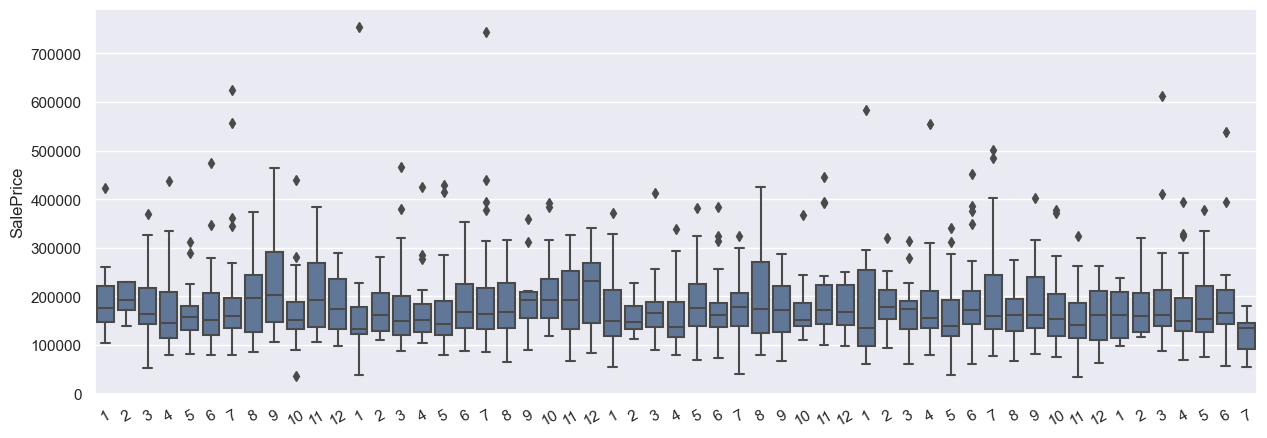

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x=(((X_train['MoSold']-1)/12) + X_train['YrSold']), y=y_train, ax=ax, color='#5876a0')
ax.set_xticklabels(labels=list(range(1,13))*4+list(range(1,8)), rotation=30);

* `_Living_Area` (cuantitativa): número total de pies cuadrados en la casa.
* `_LowQualFin_ratio` (quantitative): proporción de pies cuadrados de sótano con acabado de baja calidad en todas las plantas.
* `_Rooms/SF` (cuantitativa): número de habitaciones por pie cuadrado.
* `_Time2sale` (cuantitativa): años transcurridos entre la fecha de construcción y la fecha de venta.
* `_Time2remod` (cuantitativa): años transcurridos entre la fecha de construcción y la fecha de remodelación.
* `_Time_remod2sale` (cuantitativa): años transcurridos entre la fecha de remodelación y la fecha de venta.
* `_TopZone` (cualitativa): indica las casas ubicadas en FV (Floating Village Residential), RL (Residential Low Density) y RP (Residential Low Density Park). Aunque no hay observaciones en el conjunto de datos con casas en RP, incluimos esta zona en el set de zonas más caras, elaborada a partir del siguiente grupo simple:

In [10]:
X_train.groupby(['MSZoning'])[['SalePrice']].apply(lambda x: np.round(x.mean(), 2)).sort_values(by='SalePrice', 
                                                                                                ascending=False)

,SalePrice
MSZoning,
FV,214014.06
RL,191004.99
RH,131558.38
RM,126316.83
C (all),74528.00


* `_Total_Baths` (cuantitativa): número total de baños, incluidos los medios baños sobre el nivel del suelo, y los baños y medios baños en el sótano.
* `_Unfinished` (cuantitativa): casas con cualquiera de sus predictores en el conjunto de datos que describen una parte o área sin terminar.

In [11]:
X_train.drop(['SalePrice'], axis=1, inplace=True)
# In order to ease isin()'s:
bestnei = ['StoneBr', 'NridgHt', 'Veenker', 'Somerst', 'Timber', 'Blmngtn', 'CollgCr', 'NoRidge', 'Mitchel']
notbestnei = [f for f in X_train['Neighborhood'].unique() if f not in bestnei]
topzone = ['FV', 'RL', 'RP']
X_train['_Baths/Rooms'] = (X_train['BsmtFullBath'] + X_train['BsmtHalfBath'] + X_train['FullBath'] + 
                         X_train['HalfBath']) / X_train['TotRmsAbvGrd']
X_train['_Baths/SF'] = (X_train['BsmtFullBath'] + X_train['BsmtHalfBath'] + X_train['FullBath'] + 
                      X_train['HalfBath']) / (X_train['TotalBsmtSF'] + X_train['GrLivArea'])
X_train['_BsmtUnfin_ratio'] = np.where((X_train['TotalBsmtSF']==0), 0, X_train['BsmtUnfSF']/X_train['TotalBsmtSF'])
X_train['_Condition'] = (X_train['Condition1'] + ',' + 
                       X_train['Condition2']).apply(lambda x: pd.Series(sorted(re.split('\,', x))).str.cat(sep='/'))
X_train['_Condition_Artery'] = X_train['_Condition'].apply(lambda x: np.where(('Artery' in x), 1, -1))
X_train['_Condition_Feedr'] = X_train['_Condition'].apply(lambda x: np.where(('Feedr' in x), 1, -1))
X_train['_Condition_Norm'] = X_train['_Condition'].apply(lambda x: np.where(('Norm' in x), 1, -1))
X_train['_Condition_PosN'] = X_train['_Condition'].apply(lambda x: np.where(('PosN' in x), 1, -1))
X_train['_Condition_RRAe'] = X_train['_Condition'].apply(lambda x: np.where(('RRAe' in x), 1, -1))
X_train['_Condition_RRNn'] = X_train['_Condition'].apply(lambda x: np.where(('RRNn' in x), 1, -1))
X_train['_Condition_RRAn'] = X_train['_Condition'].apply(lambda x: np.where(('RRAn' in x), 1, -1))
X_train['_Condition_PosA'] = X_train['_Condition'].apply(lambda x: np.where(('PosA' in x), 1, -1))
X_train['_Condition_RRNe'] = X_train['_Condition'].apply(lambda x: np.where(('RRNe' in x), 1, -1))
X_train['_Connected'] = X_train['_Condition'].apply(lambda x: np.where((('Feedr' in x)|('Artery'in x)), 1, -1))
X_train['Exterior2nd'] = X_train['Exterior2nd'].str.replace('Wd Shng', 'WdShing')
X_train['Exterior2nd'] = X_train['Exterior2nd'].str.replace('CmentBd', 'CemntBd')
X_train['Exterior2nd'] = X_train['Exterior2nd'].str.replace('Brk Cmn', 'BrkComm')
X_train['_Exterior'] = (X_train['Exterior1st'] + ',' + 
                      X_train['Exterior2nd']).apply(lambda x: pd.Series(re.split('\,', x)).str.cat(sep='/'))
X_train['_Exterior_AsbShng'] = X_train['_Exterior'].apply(lambda x: np.where(('AsbShng' in x), 1, -1))
X_train['_Exterior_AsphShn'] = X_train['_Exterior'].apply(lambda x: np.where(('AsphShn' in x), 1, -1))
X_train['_Exterior_BrkComm'] = X_train['_Exterior'].apply(lambda x: np.where(('BrkComm' in x), 1, -1))
X_train['_Exterior_BrkFace'] = X_train['_Exterior'].apply(lambda x: np.where(('BrkFace' in x), 1, -1))
X_train['_Exterior_CBlock'] = X_train['_Exterior'].apply(lambda x: np.where(('CBlock' in x), 1, -1))
X_train['_Exterior_CemntBd'] = X_train['_Exterior'].apply(lambda x: np.where(('CemntBd' in x), 1, -1))
X_train['_Exterior_HdBoard'] = X_train['_Exterior'].apply(lambda x: np.where(('HdBoard' in x), 1, -1))
X_train['_Exterior_ImStucc'] = X_train['_Exterior'].apply(lambda x: np.where(('ImStucc' in x), 1, -1))
X_train['_Exterior_MetalSd'] = X_train['_Exterior'].apply(lambda x: np.where(('MetalSd' in x), 1, -1))
X_train['_Exterior_Other'] = X_train['_Exterior'].apply(lambda x: np.where(('Other' in x), 1, -1))
X_train['_Exterior_Plywood'] = X_train['_Exterior'].apply(lambda x: np.where(('Plywood' in x), 1, -1))
X_train['_Exterior_Stone'] = X_train['_Exterior'].apply(lambda x: np.where(('Stone' in x), 1, -1))
X_train['_Exterior_Stucco'] = X_train['_Exterior'].apply(lambda x: np.where(('Stucco' in x), 1, -1))
X_train['_Exterior_VinylSd'] = X_train['_Exterior'].apply(lambda x: np.where(('VinylSd' in x), 1, -1))
X_train['_Exterior_Wd Sdng'] = X_train['_Exterior'].apply(lambda x: np.where(('Wd Sdng' in x), 1, -1))
X_train['_Exterior_WdShing'] = X_train['_Exterior'].apply(lambda x: np.where(('WdShing' in x), 1, -1))
X_train['_Date_Sold'] = ((X_train['MoSold']-1)/12) + X_train['YrSold']
X_train['_LowQualFin_ratio'] = X_train['LowQualFinSF']/(X_train['TotalBsmtSF'] + X_train['GrLivArea'])
X_train['_Railed'] = X_train['_Condition'].apply(lambda x: np.where(('RR' in x), 1, -1))
X_train['_Rooms/SF'] = X_train['TotRmsAbvGrd'] / (X_train['TotalBsmtSF'] + X_train['GrLivArea'])
X_train['_Time2Sale'] = X_train['_Date_Sold'] - X_train['YearBuilt']
X_train['_Time2Remod'] = X_train['YearRemodAdd'] - X_train['YearBuilt']
X_train['_Time_Remod2Sale'] = X_train['_Date_Sold'] - X_train['YearRemodAdd']
X_train['_TopZone'] = X_train['MSZoning'].apply(lambda x: 1 if x in topzone else -1)
X_train['_Total_Baths'] = X_train['BsmtFullBath']+X_train['BsmtHalfBath']+X_train['FullBath'] + X_train['HalfBath']
X_train['_Unfinished'] = np.where(((X_train['GarageFinish']=='Unf')|(X_train['MSSubClass']==45)|
                                 (X_train['HouseStyle']=='1.5Unf')|(X_train['HouseStyle']=='2.5Unf')|
                                 (X_train['BsmtUnfSF']==0)), 1, -1)
droplist = ['YrSold', 'MoSold', '_Condition', 'Condition1', 'Condition2', '_Exterior', 'Exterior1st', 
            'Exterior2nd'] 
X_train.drop(droplist, axis=1, inplace=True)
X_train['MSSubClass'] = X_train['MSSubClass'].apply(str)
quantitative = [feat for feat in X_train.columns if feat not in qualitative]
qualitative = [feat for feat in X_train.columns if feat not in quantitative]

En algunas pipelines agrego un objeto para crear variables con promedios como parte del flujo de trabajo. Si crease estas variables de antemano y, por lo tanto, las agregase al conjunto con el que alimentamos la pipeline, estaría entrenando y validando modelos con información de todo el conjunto durante el proceso de validación cruzada.

Luego, mi objetivo es prevenir esta captura creando variables con promedios del subconjunto de entrada al modelo que, en el proceso de validación cruzada para optimizar los parámetros, será el set de entrenamiento.


### Transformación de variables
He usado la familia de transformaciones Box Cox en scipy que, si no obtiene una lambda fija, encuentra la lambda que maximiza la función de probabilidad logarítmica:

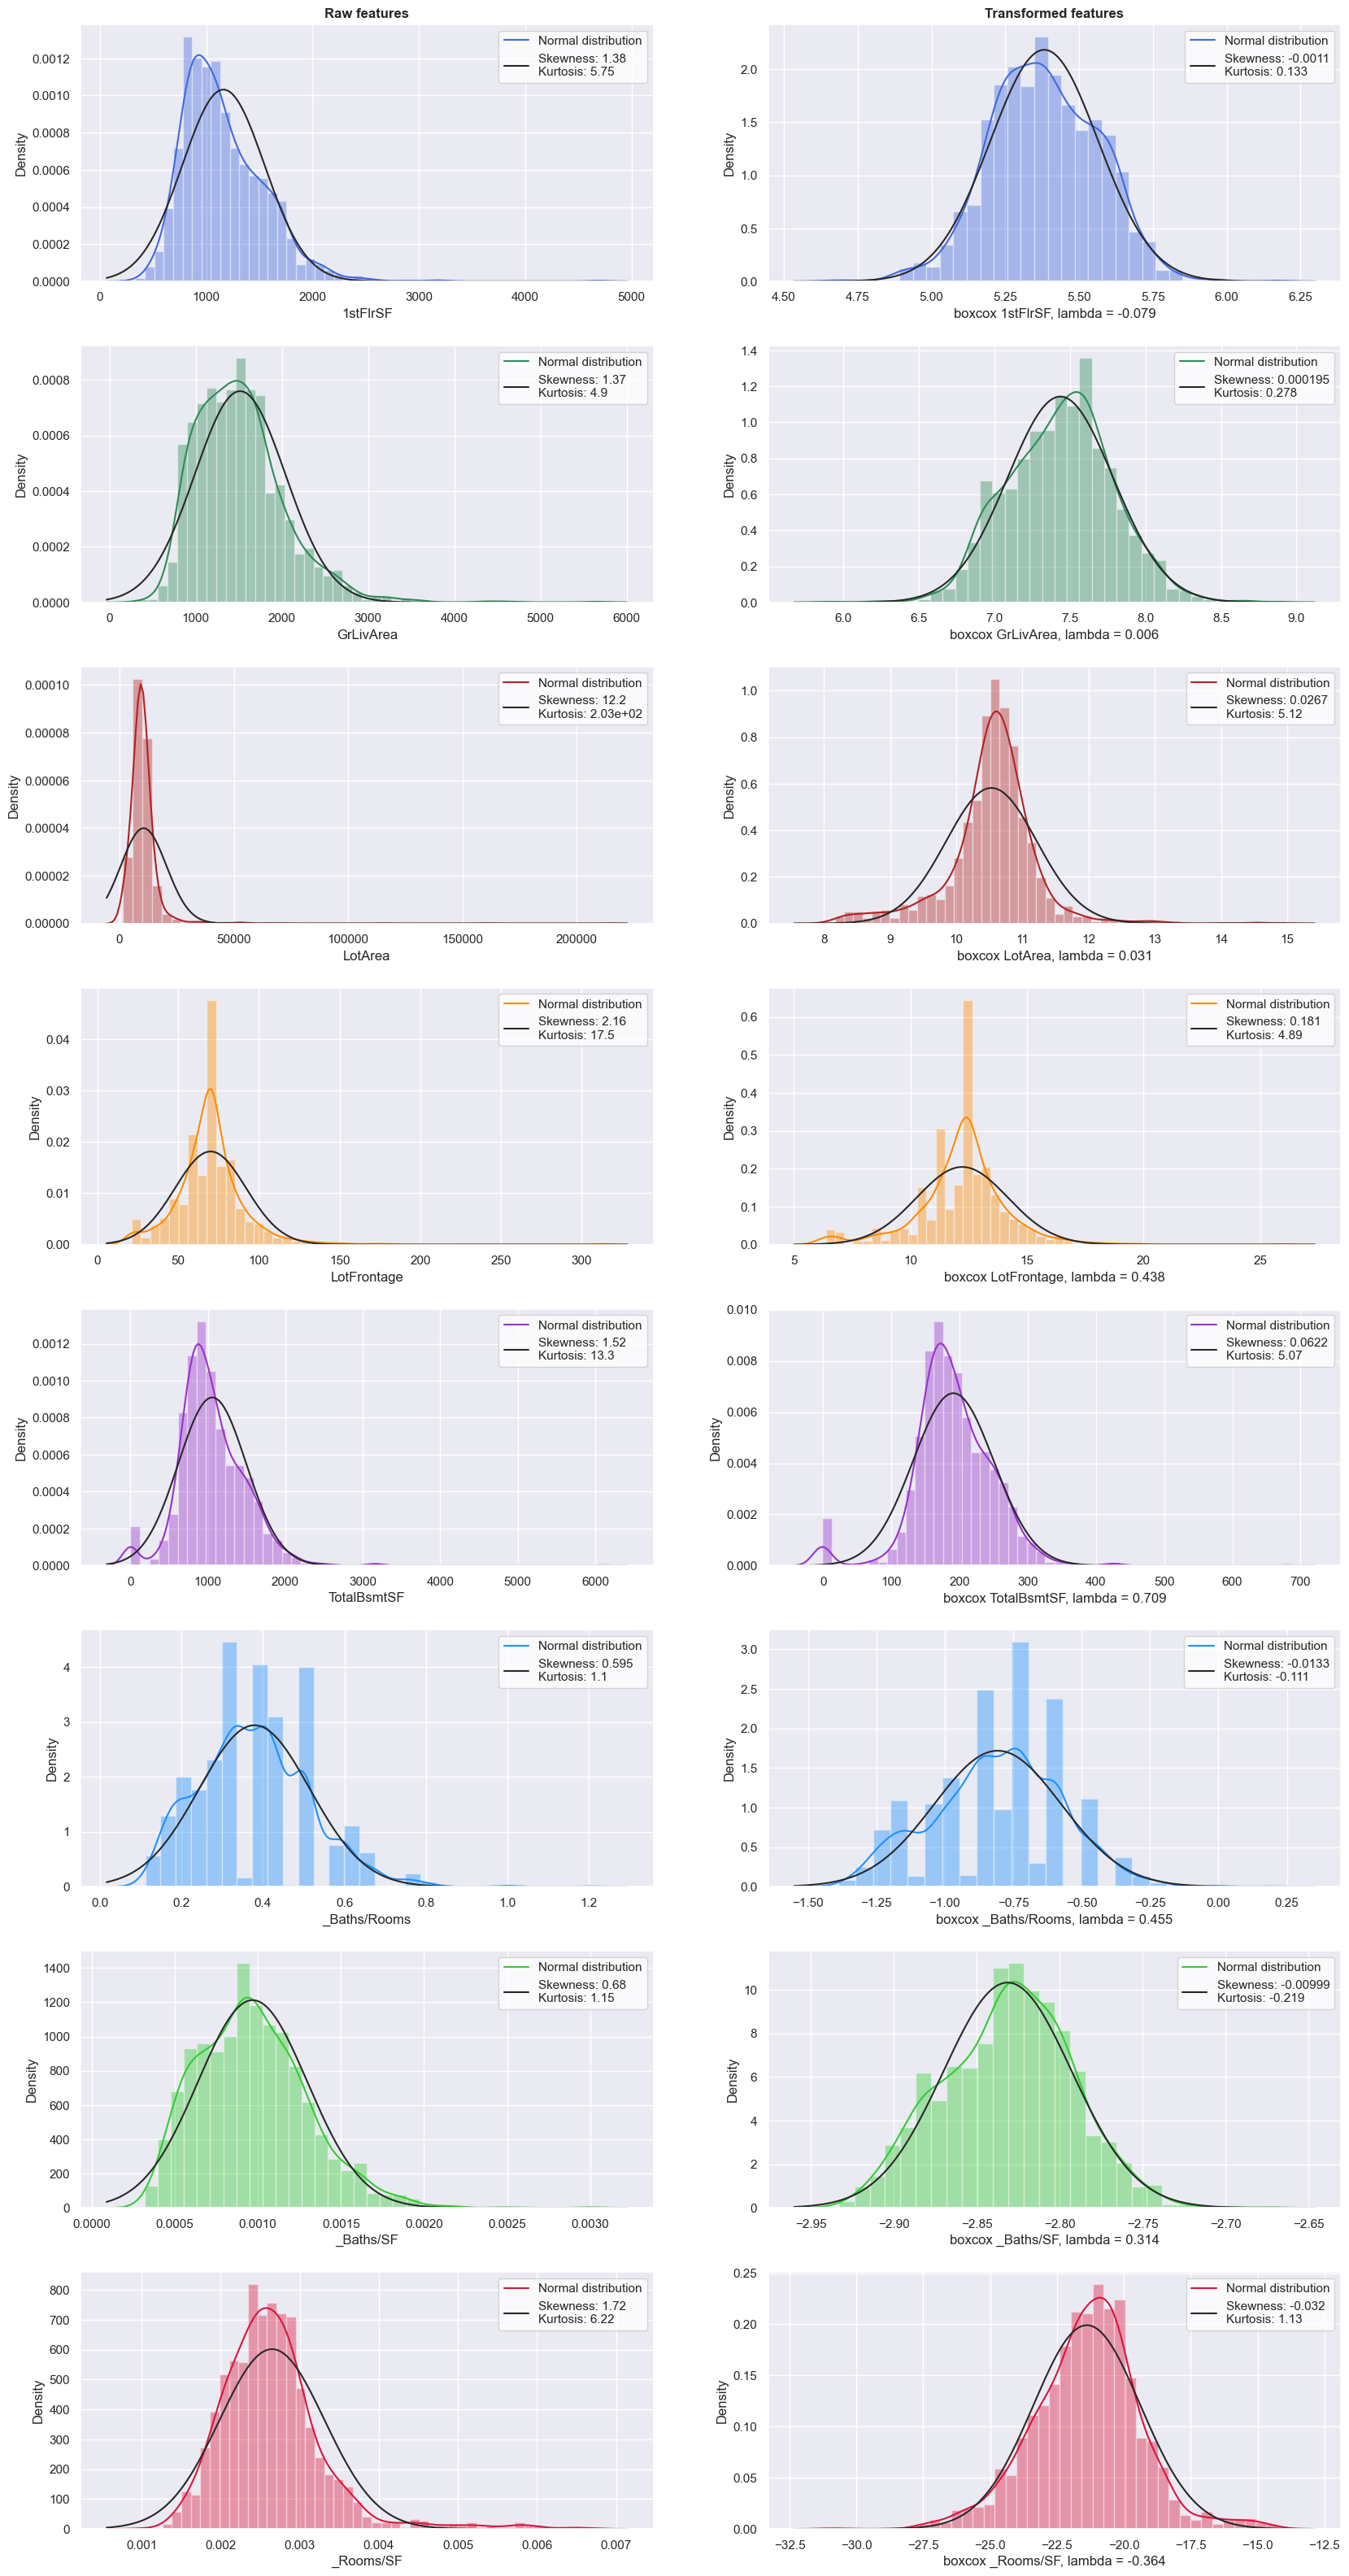

In [12]:
# Select the n_features to plot:
n_features2plot = 8
lmbdas = pd.Series()
features2transform = ['1stFlrSF', 'GrLivArea', 'LotArea', 'LotFrontage', 'TotalBsmtSF', 
                      '_Baths/Rooms', '_Baths/SF', '_Rooms/SF']
colours = ['royalblue', 'seagreen', 'firebrick', 'darkorange', 'darkorchid', 'dodgerblue', 
           'limegreen', 'crimson']
fig = plt.figure(figsize=(20, n_features2plot*5))
plt.subplots_adjust(hspace=0.25)
for colour, (i, feat) in zip(colours, enumerate(features2transform, start=1)):
    feature =  X_train[feat].fillna(X_train[feat].mean())
    if i<=n_features2plot:
        ax=plt.subplot(n_features2plot, 2, i+i-1)
        if (i==1):
            ax.set_title("Raw features", fontdict={'fontweight':'bold'})
        sns.distplot(feature, ax=ax, color=colour, fit=norm)
        ax.legend(['Normal distribution', 'Skewness: {:.3}\nKurtosis: {:.3}'.format(X_train[feat].skew(), 
                                                                                    X_train[feat].kurt())], 
                  loc='best', facecolor='white', frameon = True);
    
    if feature.min()==0:
        feature, lmbdas.loc[(i-1)] =  boxcox(feature+0.1)
    else:
        feature, lmbdas.loc[(i-1)] =  boxcox(feature)
    if i<=n_features2plot:
        ax=plt.subplot(n_features2plot, 2, 2*i)
        if i==1:
            ax.set_title("Transformed features", fontdict={'fontweight':'bold'})
        sns.distplot(feature, ax=ax, color=colour, fit=norm)
        ax.legend(['Normal distribution', 'Skewness: {:.3}\nKurtosis: {:.3}'.format(skew(feature), 
                                                                                    kurtosis(feature))],
                  loc='best', facecolor='white', frameon = True);
        ax.set_xlabel("boxcox {}, lambda = {}".format(feat, round(lmbdas.loc[(i-1)], 3)))
y_train = np.log(y_train)

Incluyo otro objeto en la pipeline para transformar algunas variables, pero con una lista de lambdas que ya hemos calculado anteriormente usando el conjunto completo.

### Codificación de variables cualitativas
Para poder codificar correctamente los datos, sin importar cuáles sean las observaciones en cada conjunto de validación, se necesitará un conjunto de categorías:

In [13]:
categories = list(itertools.chain.from_iterable((var + '_' + str(value) 
                                                 for value in np.unique(X_train[var].dropna())) 
                                                for var in qualitative))
avg_features = ['_Neighbs_GarageYrBlt_mean', '_Neighbs_GrLivArea_mean', '_Neighbs_LotArea_mean', 
                '_Neighbs_LotFrontage_mean', '_Neighbs_OverallCond_mode', '_Neighbs_OverallQual_mode', 
                '_Neighbs_GarageYrBlt_offset', '_Neighbs_GrLivArea_offset', '_Neighbs_LotArea_offset', 
                '_Neighbs_LotFrontage_offset', '_Neighbs_OverallCond_offset', '_Neighbs_OverallQual_offset']
columns_w_dummies = quantitative + categories
columns_w_avg_n_dummies = quantitative + avg_features + categories
columns_w_avg =  X_train.columns.tolist() + avg_features
categories[:5]

['MSSubClass_120',
 'MSSubClass_160',
 'MSSubClass_180',
 'MSSubClass_190',
 'MSSubClass_20']

Justo antes de cambiar la escala de las variables con un objeto `StandardScaler` de sklearn, incluyo o un objeto `Get_Dummies` o un `Get_Categorical` para codificar las variables en el conjunto pero con todas las categorías del conjunto completo, calculadas anteriormente.

La razón de pasar esta lista de categorías es evitar que los estimadores reciban diferentes conjuntos de predictores codificados en algunas particiones (_folds_) durante el proceso de validación cruzada: se espera que en conjuntos pequeños, al realizar la validación cruzada, los sets de datos después de una división no incluyan todo el conjunto de categorías en la variable cualitativa respectiva.


## Modelado

He escrito [tres clases](utils/validation.py “clases de validación”) que se utilizan en esta sección:

- `PipeTunerCV`, que se utiliza para optimizar los parámetros pasados de los estimadores en los pipelines, prevaleciendo los valores de estos parámetros con RMSE de validación cruzada más bajos sobre los demás. Además, incluyo algunos métodos para dibujar los gráficos de los coeficientes de las pipelines con los regresores Ridge, Lasso y ElasticNet, y la importancia de las variables del regresor de bosque aleatorio.

- `BoostingTunerCV`, que se utiliza para optimizar los parámetros preestablecidos de los estimadores fuera de las pipelines y para trazar la importancia de las características de los predictores y la curva de aprendizaje del modelo.

- `WeightedAverage`: se utiliza para seleccionar la combinación de pipelines que produce el mejor rendimiento.

Para evaluar cómo de bien generalizan los estimadores, utilizo la raíz cuadrada del error cuadrático medio evaluado por validación cruzada usando 5 divisiones o _folds_:

In [14]:
# 5-Folds cross-validator enabling shuffling data before splitting
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

El conjunto de datos consta de muchas dimensiones en comparación con el número total de observaciones, por lo tanto, modelos capaces de reducir los coeficientes de cada predictor -y bueno con datos dispersos- puede ser un buen punto de partida.

> Mientras que la regresión de Ridge con una norma ℓ2 encoge los coeficientes hacia cero y reduce la importancia de variables altamente correlacionadas, Lasso y ElasticNet -con una norma ℓ1 y un compromiso entre las normas ℓ1 y ℓ2 respectivamente- también pueden regularizar ya que cuando el parámetro de control de la penalización ℓ1 se vuelve lo suficientemente grande, obliga a algunos de los coeficientes a ser iguales a cero, descartando posteriormente su predictor asociado de la elaboración de una futura predicción.

In [15]:
# Transformers to be included in the Pipeline or in the creation of transformed sets
imp_median = Imputer(columns=quantitative, fillna='median')
imp_median_bynei = Imputer(columns=quantitative, fillna='median', groupby='Neighborhood')
av_ft = HousePrices_AvgFeat()
bc = HousePrices_BoxCox(features=features2transform, lmbda=lmbdas)
gd = Get_Dummies(categories, qualitative, ['OverallCond', 'OverallQual'])
gc = Get_Categorical(categories, qualitative)
st_sc = StandardScaler()

In [16]:
# The fitting procedure of some models will run on a distributed scheduler.
# I'll enclose them in separate contexts for displaying purposes.
client = Client(processes=False)

### Ridge

In [17]:
pipe_ridge = make_pipeline(imp_median, av_ft, bc, gd, st_sc, Ridge())
tuner = PipeTunerCV(estimator=pipe_ridge, kfold=kfold, param_grid = {'alpha':np.linspace(785, 787, 25)}, 
                    metrics=rmse)
with joblib.parallel_backend('dask'):
    tuner.tune(X_train, y_train)
print("Best parameters: {}\nRMSE-CV mean: {}\nRMSE-CV std:  {}".format(tuner.best_params_, 
                                                                       tuner.metrics_cv_.mean(), 
                                                                       tuner.metrics_cv_.std()))

Best parameters: {'alpha': 786.9166666666666}
RMSE-CV mean: 0.135612207285767
RMSE-CV std:  0.029147504602828545


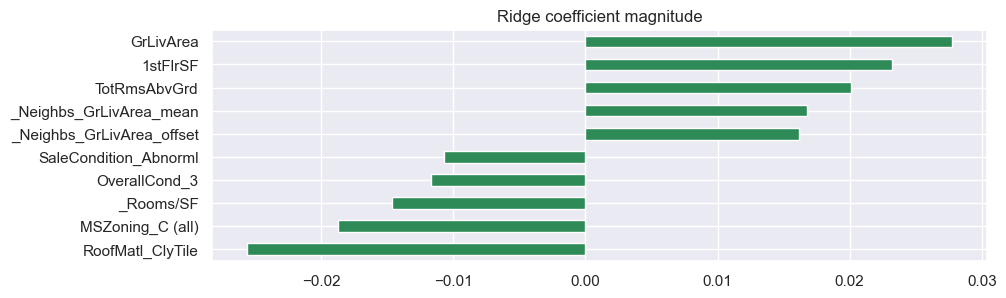

In [18]:
sns.set(font_scale=1)

tuner.plot(X_train, y_train, columns_w_avg_n_dummies, slice_=np.r_[0:5, -5:0])

### Lasso

In [19]:
pipe_lasso = make_pipeline(imp_median_bynei, av_ft, bc, gd, st_sc, Lasso())
tuner = PipeTunerCV(estimator=pipe_lasso, kfold=kfold, param_grid = {'alpha':np.linspace(0.0049, 0.0051, 25)}, 
                    metrics=rmse)
with joblib.parallel_backend('dask'):
    tuner.tune(X_train, y_train)
print("Best parameters: {}\nRMSE-CV mean: {}\nRMSE-CV std:  {}".format(tuner.best_params_, 
                                                                       tuner.metrics_cv_.mean(), 
                                                                       tuner.metrics_cv_.std()))

Best parameters: {'alpha': 0.005008333333333333}
RMSE-CV mean: 0.1283503165350137
RMSE-CV std:  0.027018197626668773


Number of features used: 88 (26.666666666666668 %)


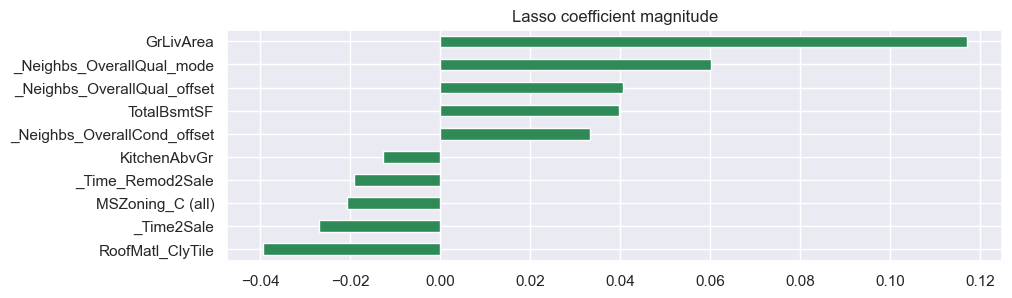

In [20]:
tuner.plot(X_train, y_train, columns_w_avg_n_dummies, slice_=np.r_[0:5, -5:0])

### Elastic Net

In [21]:
pipe_elnet = make_pipeline(imp_median_bynei, av_ft, bc, gd, st_sc, ElasticNet())
tuner = PipeTunerCV(estimator=pipe_elnet, kfold=kfold, param_grid={'alpha':np.linspace(0.004, 0.07, 7), 
                                                                   'l1_ratio': np.linspace(0.09, 0.11, 7)},
                    metrics=rmse)
with joblib.parallel_backend('dask'):
    tuner.tune(X_train, y_train)
print("Best parameters: {}\nRMSE-CV mean: {}\nRMSE-CV std:  {}".format(tuner.best_params_, 
                                                                       tuner.metrics_cv_.mean(), 
                                                                       tuner.metrics_cv_.std()))

Best parameters: {'alpha': 0.048, 'l1_ratio': 0.10666666666666666}
RMSE-CV mean: 0.13210512587352735
RMSE-CV std:  0.03315148653071479


Number of features used: 99 (30.0 %)


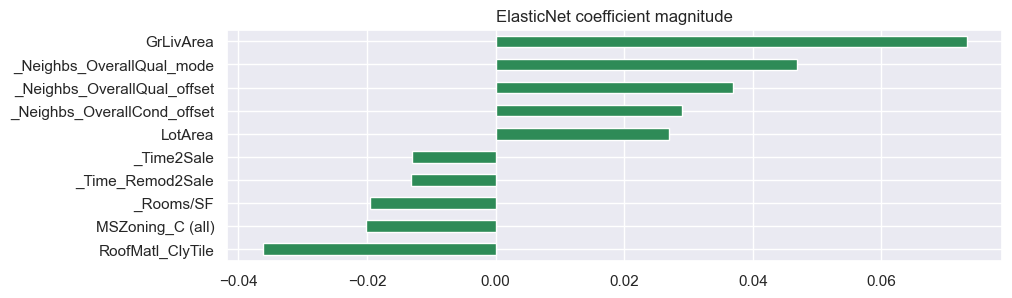

In [22]:
tuner.plot(X_train, y_train, columns_w_avg_n_dummies, slice_=np.r_[0:5, -5:0])

También se han utilizado algoritmos con kernel trick. Un núcleo polinomial en el caso de Kernel Ridge y un núcleo RBF en caso del regresor de vectores de soporte. Los parámetros de estos estimadores se optimizan mediante una grid search con validación cruzada sobre diferentes grids de parámetros definidos a continuación:

### Kernel Ridge

In [23]:
pipe_kr = make_pipeline(imp_median, av_ft, bc, gd, st_sc, KernelRidge(kernel='polynomial', 
                                                                      degree=2))
tuner = PipeTunerCV(estimator=pipe_kr, kfold=kfold, param_grid = {'alpha':np.linspace(3, 5, 7), 
                                                                  'coef0':np.linspace(2, 3, 7)}, 
                    metrics=rmse)
with joblib.parallel_backend('loky'):
    tuner.tune(X_train, y_train)
print("Best parameters: {}\nRMSE-CV mean: {}\nRMSE-CV std:  {}".format(tuner.best_params_, 
                                                                       tuner.metrics_cv_.mean(), 
                                                                       tuner.metrics_cv_.std()))

Best parameters: {'alpha': 3.6666666666666665, 'coef0': 2.3333333333333335}
RMSE-CV mean: 0.13041774327470967
RMSE-CV std:  0.029715556927921924


### Regresor de soporte vectorial

In [24]:
pipe_svr = make_pipeline(imp_median, av_ft, bc, gd, st_sc, SVR())
tuner = PipeTunerCV(estimator=pipe_svr, kfold=kfold, param_grid = {'C':np.linspace(10, 20, 5), 
                                                                   'gamma':np.linspace(1e-5, 8e-6, 5)}, 
                    metrics=rmse)
with joblib.parallel_backend('dask'):
    tuner.tune(X_train, y_train)
print("Best parameters: {}\nRMSE-CV mean: {}\nRMSE-CV std:  {}".format(tuner.best_params_, 
                                                                       tuner.metrics_cv_.mean(), 
                                                                       tuner.metrics_cv_.std()))

Best parameters: {'C': 15.0, 'gamma': 8.5e-06}
RMSE-CV mean: 0.1328282252632063
RMSE-CV std:  0.028325335969176066


### Regresor de bosque aleatorio

También he creado una pipeline que contiene un regresor de bosque aleatorio. Aumentar el número de árboles mejorará ligeramente el rendimiento, aunque seguirá siendo peor que el rendimiento de los estimadores anteriores para este conjunto de datos. 

Asigno 25 a n_iter para randomizar la búsqueda dado que de esta manera se limitará la longitud de cada grid de parámetros, si el valor de _n\_iter_ es inferior a la longitud del array de combinaciones, y se muestrea desde esta lista aleatoriamente sin reemplazo:

In [25]:
pipe_rfr = make_pipeline(imp_median, av_ft, gc, RandomForestRegressor(max_features=1.0, 
                                                                      n_estimators=250, 
                                                                      random_state=0))
tuner = PipeTunerCV(estimator=pipe_rfr, kfold=kfold, param_grid = {'max_depth': list(range(10, 20, 4)),
                                                                   'min_samples_leaf': list(range(1, 4)),
                                                                   'min_samples_split': list(range(2, 6))}, 
                    metrics=rmse, n_iter=25)
with joblib.parallel_backend('dask'):
    tuner.tune(X_train, y_train)
print("Best parameters: {}\nRMSE-CV mean: {}\nRMSE-CV std:  {}".format(tuner.best_params_, 
                                                                       tuner.metrics_cv_.mean(), 
                                                                       tuner.metrics_cv_.std()))

Best parameters: {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2}
RMSE-CV mean: 0.15142328361610888
RMSE-CV std:  0.020106380150246028


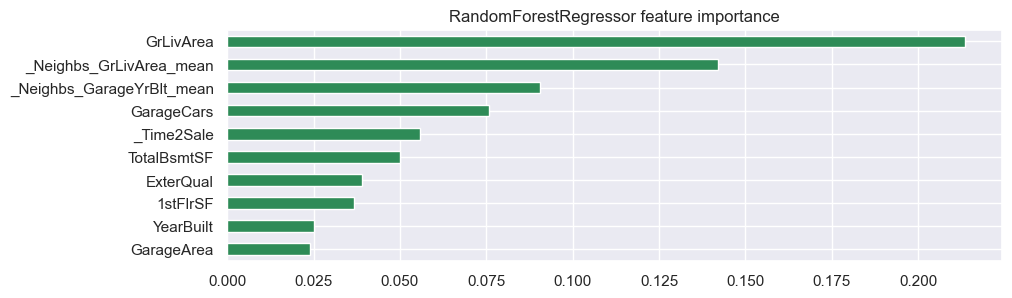

In [26]:
tuner.plot(X_train, y_train, columns_w_avg, slice_=np.arange(-10, 0))

### Regresores de potenciación del gradiente

eXtreme Gradient Boosting y Light Gradient Boosting Machine son los regresores de potenciación o _boosting_ que van a ser explorados. El primero utiliza el algoritmo de crecimiento de árboles en profundidad, mientras que el segundo, el algoritmo de crecimiento de árboles en forma de hojas.

Dado que el número de observaciones en nuestro conjunto de entrenamiento no es grande y estos conjuntos tienden a sobreajustarse en conjuntos de datos pequeños, la optimización de los parámetros es una tarea a realizar necesaria, ya que de lo contrario nuestro estimador probablemente seguiría demasiado de cerca los datos de entrenamiento y resultaría en malas predicciones. En este sentido, se ha escrito un enfoque para optimizar -o sintonizar- los parámetros en ambos regresores: `BoostingTunerCV`.

La idea principal es automatizar el proceso de búsqueda de cuadrícula, o _grid_, con validación cruzada de todos los parámetros. Estos parámetros se incluyen luego en diferentes grids: en primer lugar, los parámetros principales para controlar la complejidad del modelo, a posteriori, parámetros para agregar características de submuestreo de aleatoriedad y observaciones -para hacer el entrenamiento robusto al ruido- y, finalmente, parámetros de regularización.

He fijado la tasa de aprendizaje a 0,025 en el regresor XGB y 0,03 en el _ensemble_ LGBM y he utilizado las  funciones de validación cruzada nativas `xgb.cv` y `lgb.cv` para evaluar los modelos correspondientes que permitan rondas `early_stopping_round`.

De esta manera, el entrenamiento se detiene en cualquiera de los subconjuntos si la raíz cuadrada del error cuadrático medio (métrica seleccionada) de los datos de validación no mejora en las rondas dadas. El número de la última ronda será el número total de estimadores que se necesitan para realizar una tarea óptima con los parámetros dados.

In [27]:
# Dataset to train the gradient boosting regressors. Once the parameters of the models are tuned, the models are 
# chained to a GetDummies class object in Pipelines. All the Pipelines will then be fit with same set: X_train
X_train_boosting = gd.fit_transform(X_train)

#### eXtreme Gradient Boosting

Como se señaló anteriormente y como podemos ver a continuación, el modelo tiende a sobreajustar los datos de entrenamiento usando los parámetros estándar incluso deteniendo el entrenamiento si no hay mejora después de 100 ciclos completos (o iteraciones sobre el conjunto de datos). El rendimiento del conjunto mejora notáblemente a medida que el número de estimadores aumenta a 300. En cambio, cerca de 800 el error de entrenamiento sigue disminuyendo sustancialmente en comparación con el rmse de prueba, es decir, el modelo está corrigiendo errores en cada árbol posterior que no ayudará cuando se trata de predecir sobre nuevos datos.

Por lo tanto, el entrenamiento se puede detener antes estableciendo un valor más bajo de `early_stopping_rounds` para evitar el sobreajuste, es decir, para matener una buena generalización, como podemos ver en el gráfico de la derecha:

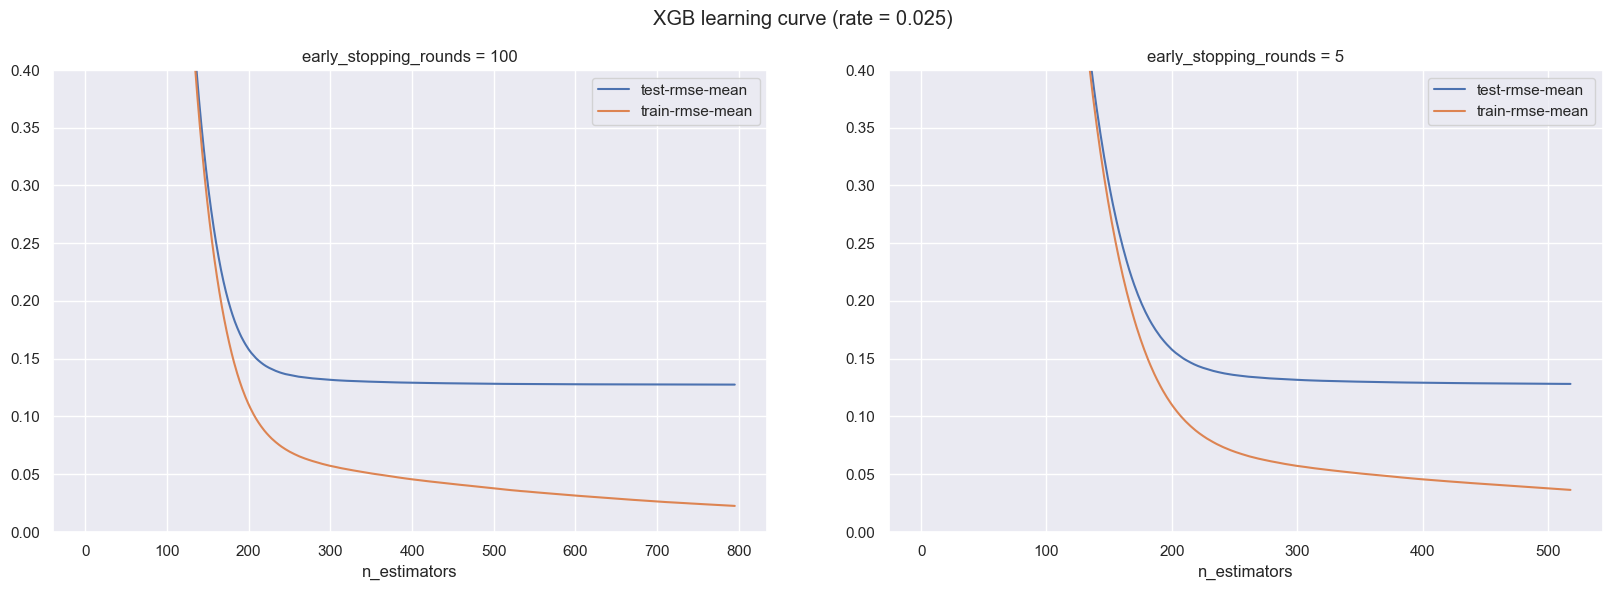

In [28]:
xgb_cv={}
learning_rate = 0.025
esrs = [100, 5]
params = {'learning_rate':learning_rate, 'objective':'reg:linear', 'nthread':-1, 'seed':1, 'verbosity':0}
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,6))
fig.subplots_adjust(wspace=.17)
fig.suptitle("XGB learning curve (rate = {})".format(learning_rate))
for i, esr in enumerate(esrs):
    xgb_cv[i] = xgb.cv(params, xgb.DMatrix(X_train_boosting, y_train), num_boost_round=1150, 
                       folds=list(kfold.split(X_train_boosting, y_train)), metrics='rmse', 
                       early_stopping_rounds=esr, verbose_eval=False)
    xgb_cv[i].index.name = "n_estimators"
    xgb_cv[i][['test-rmse-mean', 'train-rmse-mean']].plot(ax=ax[i], title="early_stopping_rounds = "+str(esr), 
                                                          ylim=[0, 0.4])

When setting `early_stopping_rounds = 5` there is still a similar test accuracy but the model does not follow so closely the training data. Although there is still overfitting, it is not so severe:

In [29]:
for i, esr in enumerate(esrs):
    print("\n· early_stopping_rounds = "+str(esr))
    display(xgb_cv[i][['test-rmse-mean', 'train-rmse-mean']].tail(2))


· early_stopping_rounds = 100


,test-rmse-mean,train-rmse-mean
n_estimators,,
794,0.127595,0.022618
795,0.127592,0.022568



· early_stopping_rounds = 5


,test-rmse-mean,train-rmse-mean
n_estimators,,
517,0.128213,0.036486
518,0.128191,0.036433


Dado que los parámetros aún no se han optimizado para el conjunto de datos, esto fue solo una aproximación con el fin de introducir algunas propiedades inherentes de estos conjuntos y tener una idea de la curva de aprendizaje de nuestro modelo y cómo podemos atenuar parcialmente el sobreajuste manteniendo un rmse de prueba bajo.

A continuación, comenzaré a ajustar los hiperparámetros de la máquina de _boosting_ para que el rendimiento pueda mejorarse aún más:

In [30]:
# XGB parameters tuning new class early stopping every grid
param_grid = {}
param_grid[0] = {'max_depth':list(range(1,5)), 'min_child_weight':list(range(1,5))}
param_grid[1] = {'gamma': [0.1, 0.01, 0]}
param_grid[2] = {'subsample':np.arange(0., 1.01, 0.1), 'colsample_bytree':np.arange(0., 1.01, 0.1)}
param_grid[3] = {'reg_alpha':np.arange(0, 0.31, 0.05), 'reg_lambda':np.arange(0.3, 1.01,0.1)}
params = {'learning_rate':0.025, 'objective':'reg:squarederror', 'nthread':-1, 'seed':1}
model_xgb = XGBRegressor(**params)
tuner = BoostingTunerCV(model_xgb, kfold, param_grid, num_boost_round=1500, 
                        early_stopping_rounds=5, metrics='rmse')
with joblib.parallel_backend('dask'):
    tuner.tune(X_train_boosting, y_train)
print("Best parameters: {}\nRMSE-CV mean and std: {}".format(tuner.best_params_, 
                                                             rmse_cv(model_xgb, X_train_boosting, 
                                                                     y_train, kfold)))

Best parameters: {'max_depth': 4, 'min_child_weight': 3, 'gamma': 0, 'subsample': 0.9, 'colsample_bytree': 0.1, 'reg_alpha': 0.05, 'reg_lambda': 0.6000000000000001}
RMSE-CV mean and std: (0.12343821310292222, 0.019623029577543773)


In [31]:
model_xgb.get_params()['n_estimators']

950

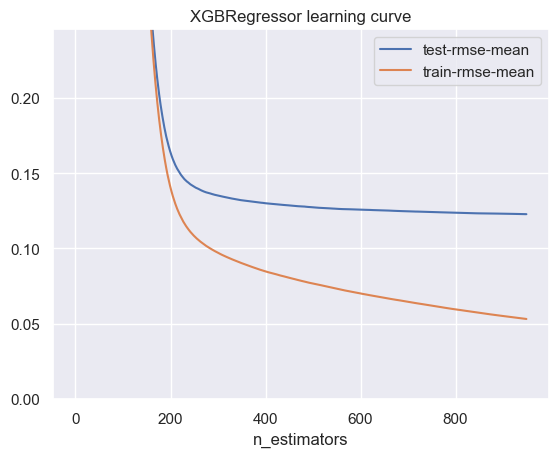

In [32]:
tuner.plot_learning_curve()

Como podemos ver en la curva de aprendizaje, después de optimizar los parámetros del modelo, el problema de sobreajuste se ha aliviado considerablemente mientras se mantiene un rmse de prueba similar, es decir, el modelo mejora su error de prueba y no sigue tan de cerca los datos de entrenamiento:

In [33]:
tuner.cv_result_.tail(2)

,test-rmse-mean,train-rmse-mean
n_estimators,,
948,0.122824,0.053196
949,0.122811,0.053162


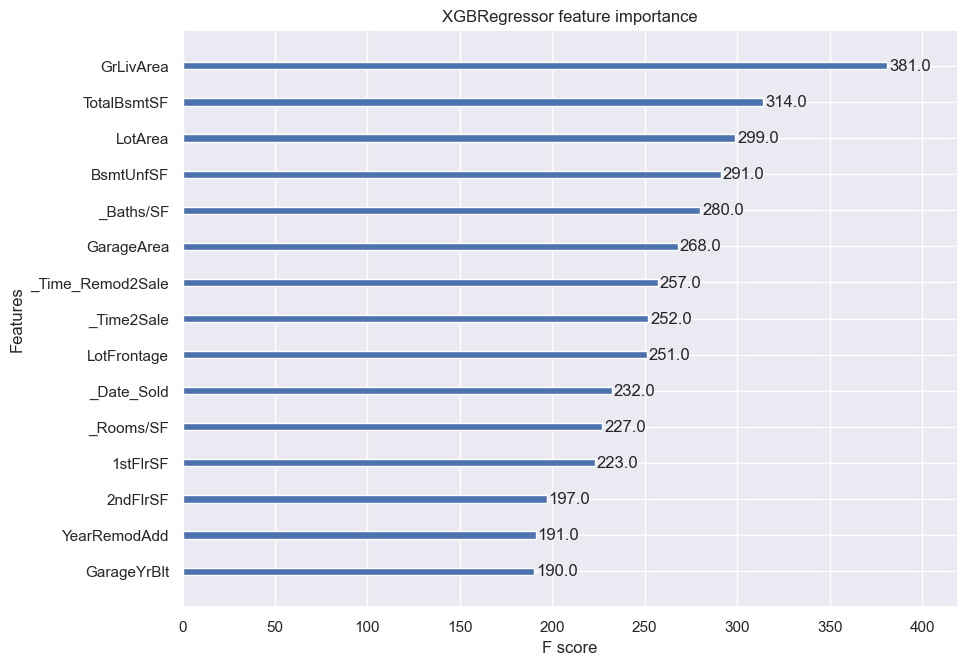

In [34]:
tuner.plot_importance(X_train_boosting, y_train, feature_names=columns_w_dummies, max_num_features=15)

Dado que no estandarizo ni introduzco valores con promedios en el conjunto de datos que se usa para los regresores _gradient boosting_ (de hecho, dejamos `np.nan` como el valor faltante especificado), el RMSE validado cruzado es exactamente el mismo para el XGB que para el Pipeline donde está encadenado:

In [35]:
pipe_xgb = make_pipeline(gd, model_xgb)
print("RMSE CV, std: ", rmse_cv(pipe_xgb, X_train, y_train, kfold))

RMSE CV, std:  (0.12343821310292222, 0.019623029577543773)


#### Light Gradient Boosting Machine
He seguido un procedimiento similar para optimizar los hiperparámetros del LGBM, sin embargo, `early_stopping_rounds` ahora se ha establecido en 10 y la tasa de aprendizaje en 0.03:

In [36]:
# LightGBM parameters tuning
param_grid = {}
param_grid[0] = {'num_leaves': list(range(2, 15)), 'min_child_samples': list(range(1, 11))}
param_grid[1] = {'min_split_gain': [0.1, 0.01, 0], 'min_child_weight':list(range(1, 4))}
param_grid[2] = {'subsample': np.arange(0.0005, 0.01, 0.001), 'colsample_bytree': np.arange(0.1, 1.0, 0.1)}
param_grid[3] = {'reg_alpha': np.arange(0,0.51,0.1), 'reg_lambda': np.arange(0,0.51,0.1)}
params = {'learning_rate': 0.03, 'objective': 'regression', 'n_estimators': 1500, 'verbosity':-1, 'silent':True}
model_lgb = LGBMRegressor(**params)
tuner = BoostingTunerCV(model_lgb, kfold, param_grid, num_boost_round=1500,
                        early_stopping_rounds=10,  metrics='rmse')
with joblib.parallel_backend('dask'):
        tuner.tune(X_train_boosting, y_train)
print("Best parameters: {}\nRMSE-CV mean and std: {}".format(tuner.best_params_,
                                                             rmse_cv(model_lgb,
                                                                     X_train_boosting,
                                                                     y_train, kfold)))

Best parameters: {'num_leaves': 12, 'min_child_samples': 1, 'min_split_gain': 0, 'min_child_weight': 1, 'subsample': 0.0005, 'colsample_bytree': 0.2, 'reg_alpha': 0.0, 'reg_lambda': 0.30000000000000004}
RMSE-CV mean and std: (0.12330942176213396, 0.020340201986866327)


In [37]:
model_lgb.get_params()['n_estimators']

889

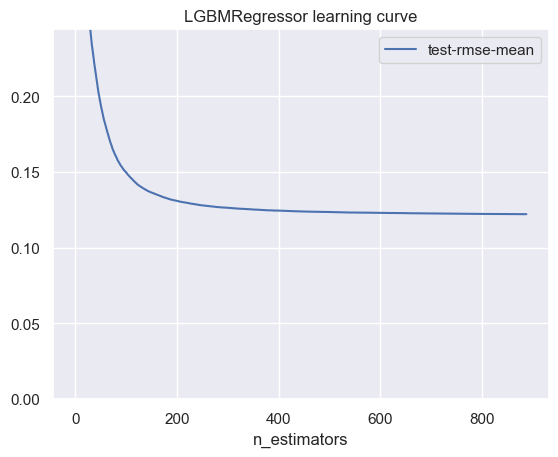

In [38]:
tuner.plot_learning_curve()

In [39]:
tuner.cv_result_.tail(2)

,test-rmse-mean
n_estimators,
887,0.122078
888,0.122067


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type


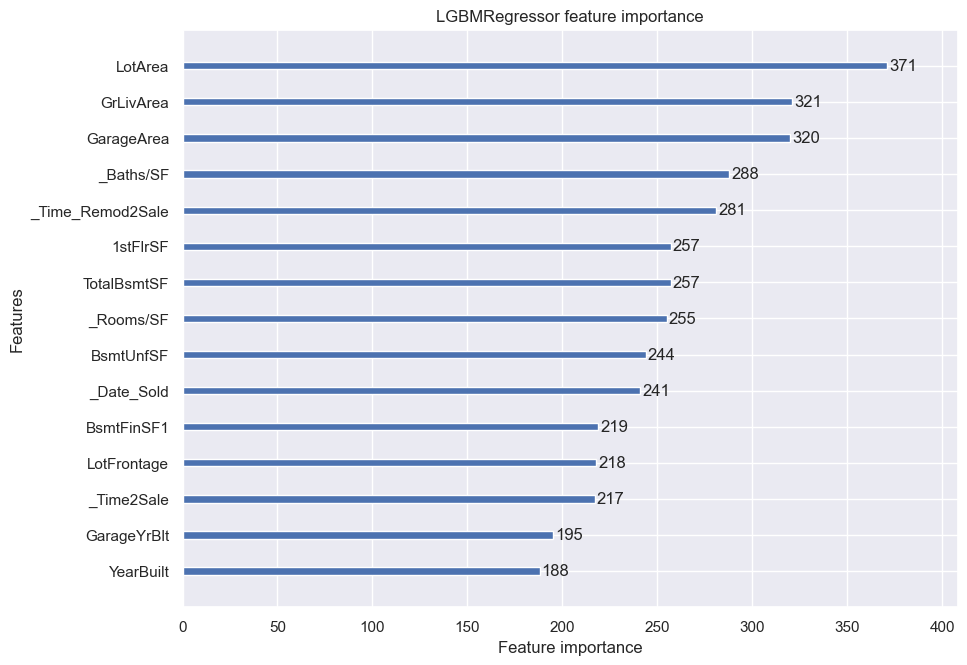

In [40]:
tuner.plot_importance(X_train_boosting, y_train, feature_names=columns_w_dummies, 
                      max_num_features=15)

In [41]:
pipe_lgb = make_pipeline(gd, model_lgb)
print("RMSE CV, std: ", rmse_cv(pipe_lgb, X_train, y_train, kfold))

RMSE CV, std:  (0.12330942176213396, 0.020340201986866327)


LGBM está generalizando ligeramente mejor en este conjunto y también permite un entrenamiento más rápido en comparación con el XGB.


### Gráficas de residuos
La siguiente figura muestra los residuos de cada estimador después de dividir el conjunto de entrenamiento, ajustar cada estimador y predecir los precios a partir del conjunto de validación. Las observaciones sobre la línea discontinua naranja oscura, o el origen, se corresponden con predicciones perfectas (residual = 0).

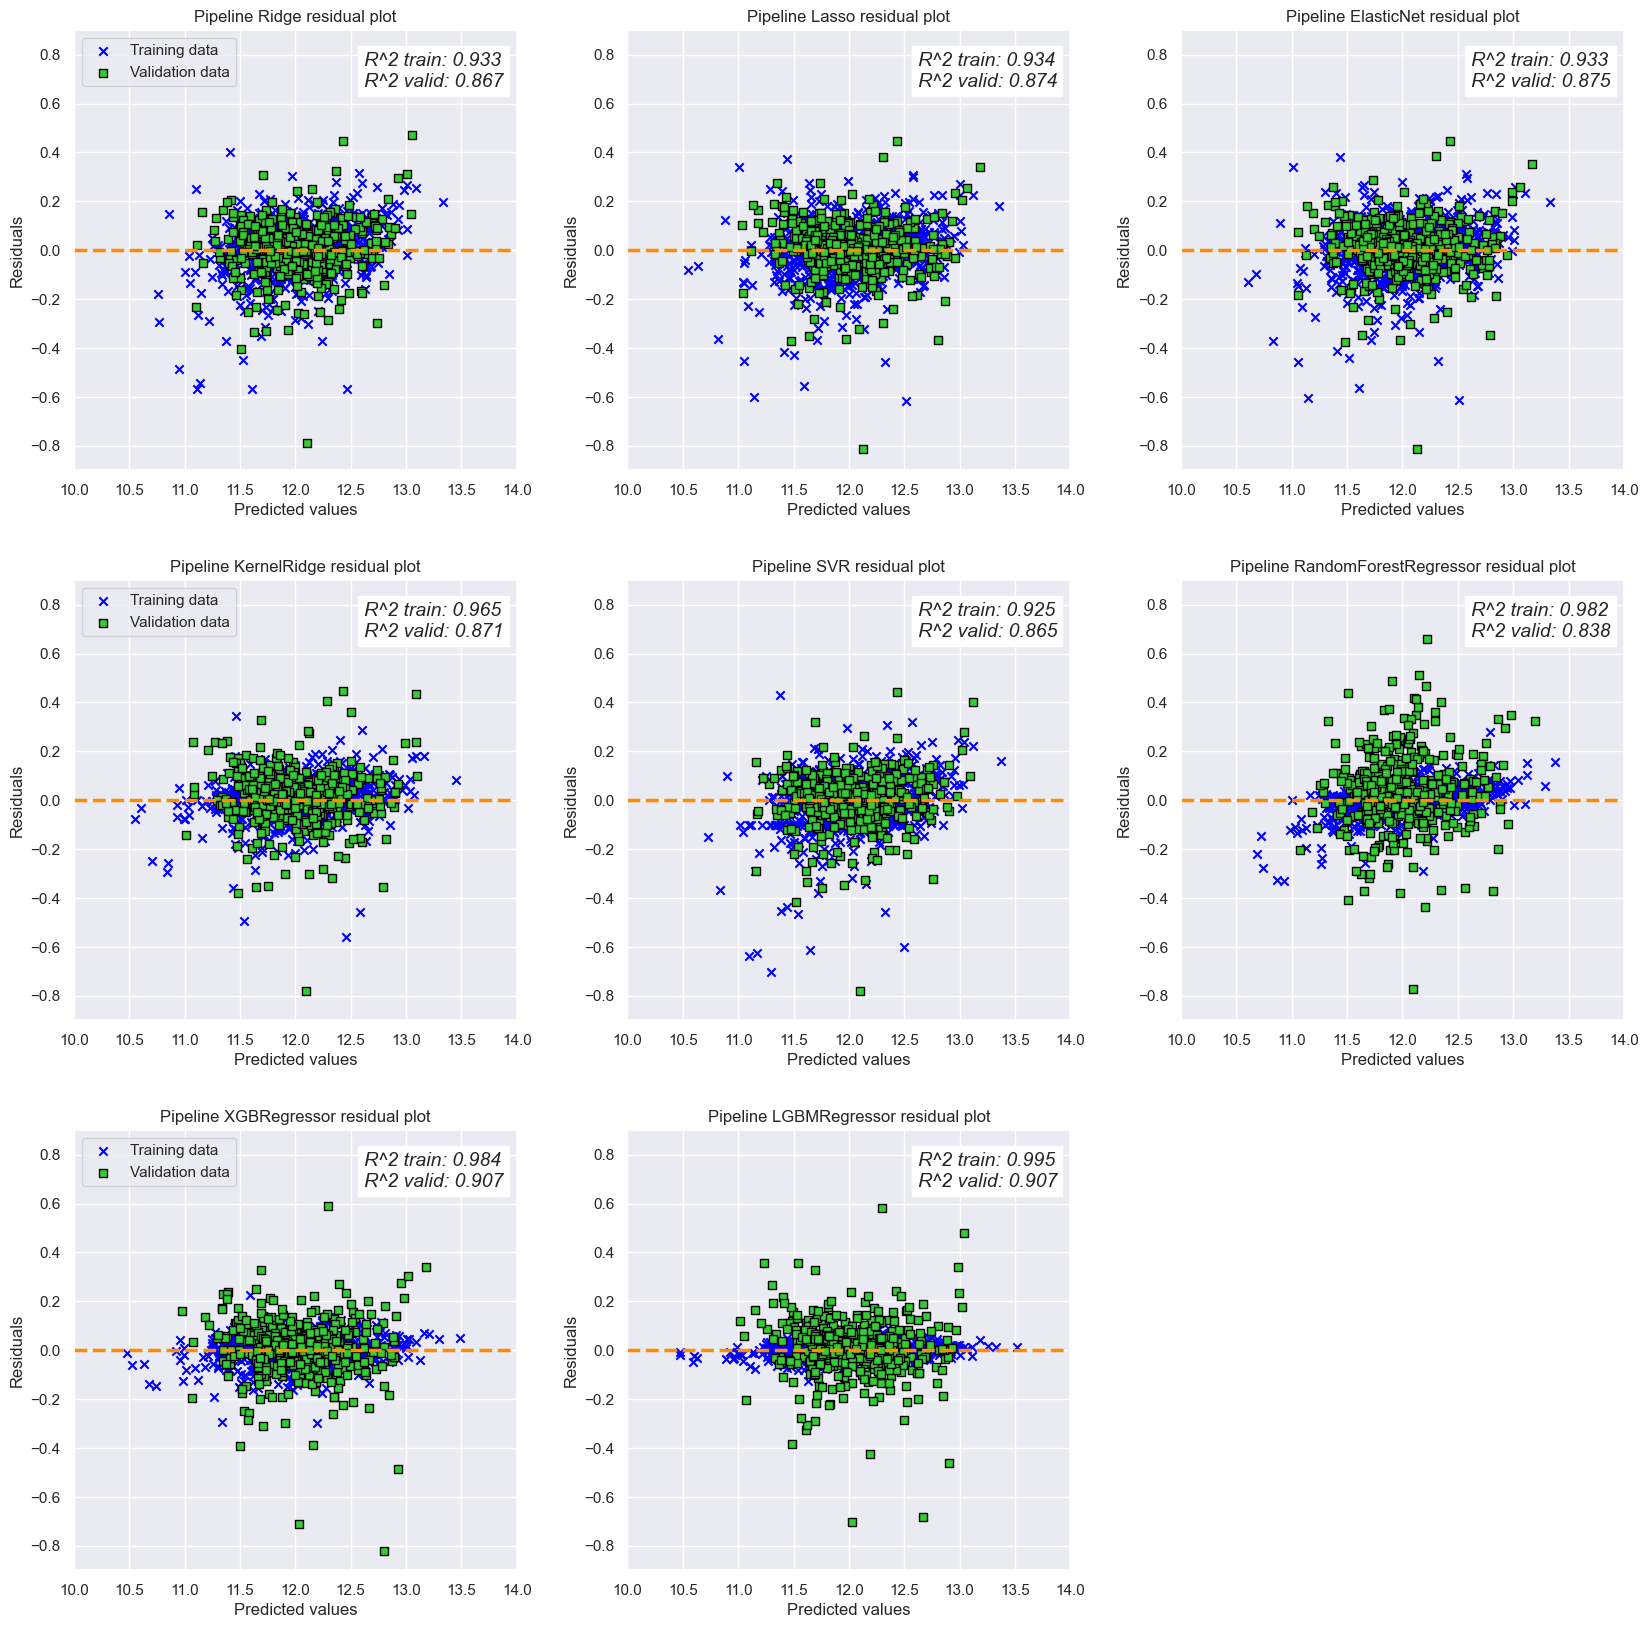

In [42]:
Xtrain, Xvalidation, ytrain, yvalidation = train_test_split(X_train, y_train, test_size=0.3, 
                                                            random_state=0, shuffle=True)
fig = plt.figure(figsize=(20, 20))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
for i, original_estimator in enumerate([pipe_ridge, pipe_lasso, pipe_elnet, pipe_kr, pipe_svr, pipe_rfr, 
                               pipe_xgb, pipe_lgb], start=1):
    ax = plt.subplot(3, 3, i)
    estimator = clone(original_estimator)
    estimator.fit(Xtrain, ytrain)
    y_train_pred = estimator.predict(Xtrain)
    y_validation_pred = estimator.predict(Xvalidation)
    ax.scatter(y_train_pred, ytrain - y_train_pred, c = "blue", marker = "x", label = "Training data", 
               edgecolors="black")
    ax.scatter(y_validation_pred, yvalidation - y_validation_pred, c = "limegreen", marker = "s", 
               label = "Validation data", edgecolors="black")
    ax.set_title(re.match(r'\w+',str(estimator))[0] + ' ' + 
                 re.match(r'\w+', str(estimator.named_steps[list(estimator.named_steps.keys())[-1]]))[0]+
                 " residual plot")
    ax.set_xlabel("Predicted values")
    ax.set_ylabel("Residuals")
    if (i-1)%3==0:
        ax.legend(loc = "upper left", frameon=True) 
    ax.text(12.62, 0.67, 'R^2 train: {:.3}\nR^2 valid: {:.3}'.format(r2_score(ytrain, y_train_pred), 
                                                                     r2_score(yvalidation, y_validation_pred)), 
            fontsize=14, style='italic', bbox={'facecolor':'white'})
    ax.hlines(y=0, xmin=10, xmax=14, lw=2.5, color='darkorange', linestyle="--")
    ax.set_xlim([10, 14])
    ax.set_ylim([-0.9, 0.9])
plt.show()

A pesar de que no hay patrones claros en los datos de validación, todavía hay algunas observaciones difíciles de predecir correctamente después de entrenar los modelos con el 70% de los datos (el resto de los datos se deja para la evaluación del modelo). Sin embargo, todos los estimadores, excepto el conjunto de árboles, funcionan bastante bien. El regresor de bosque aleatorio sobreajusta significativamente los datos de entrenamiento y, como resultado, sus predicciones son significativamente peores que las de otros regresores.

> $R ^2$ se utiliza para evaluar la precisión del modelo. Esta métrica mide la proporción de varianza que un estimador puede explicar.


### Promedio ponderado

La mayoría de las predicciones anteriores son bastante similares, pero algunas difieren, por lo que mi intención ha sido realizar un conjunto de modelos , o _ensemble_, muy simple que calcule el mejor promedio entre las predicciones de los modelos preseleccionados, es decir, algunas de estas predicciones tendrán más importancia, o peso, que otras.

Para seleccionar la mejor combinación de ponderaciones para todos los estimadores, en cada _step_ se crea un conjunto de porcentajes entre 0 y 1, de modo que todos los pesos de cada fila en el conjunto sumen exactamente uno, es decir, se computa el 100% de una estimación. Finalmente, cada columna contiene todos los pesos que se calcularán para cada estimador.

Por ejemplo, digamos que una de las filas es _[0.25, 0.0, 0.35, 0.1, 0.3]_, estos serían los pesos necesarios para calcular una estimación tomando el 25% de las predicciones del primer estimador, cero de la estimación del segundo modelo, 35% del tercer modelo, diez por ciento del cuarto modelo y 30% del quinto. Estos pesos se multiplican, por tanto, por las predicciones de cada modelo. Pero estas predicciones son para un conjunto de reserva, o _holdout_, ya que todo este proceso se evalúa mediante una validación cruzada de _k_ particiones.

Entonces, una vez que los pesos seleccionados se multiplican por las predicciones de este conjunto reservado, el promedio resultante se puntúa con la función `rmse` y luego el resultado de la métrica se almacena en una de las celdas del conjunto de predicciones que, al final de este proceso, contendrá una columna por partición, o _fold_, de la validación cruzada y una fila por posible combinación de todos los pesos o tasas preespecificados.

> Las tasas se calculan una vez que se llama al método de ajuste (_fit_) de un objeto de esta clase. Cuanto mayor sea el número de modelos incluidos en el conjunto para un paso dado, más tiempo llevará calcular la combinación de tasas.

En conclusión, en caso de que creáramos un objeto `Weighted_Average` de cinco estimadores con un _step_ de cinco, las ponderaciones utilizadas como ejemplo anteriormente estarían en una de las filas en el marco de datos de predicciones, y cada valor de esta fila sería su correspondiente _rmse_ del respectivo subconjunto reservado, o _holdout fold_. La media a lo largo de esta fila sería la raíz cuadrada con validación cruzada del error cuadrático medio de una combinación de promedios ponderados. Los pesos seleccionados serían aquellos para cuyo RMSE-CV sea menor, es decir, los pesos que arrojen el RMSE-CV más bajo entre 10626 combinaciones.

En primer lugar, incluimos todos los estimadores -salvo `XGBRegressor` y `RandomForestRegressor`- con un _step_ de 10, de modo que no se necesite demasiado tiempo para crear la combinación de pesos:

In [43]:
wa6e = Weighted_Average([pipe_ridge, pipe_lasso, pipe_elnet, pipe_kr, pipe_xgb, pipe_lgb], 
                        kfold, step=0.1, metrics=rmse)
wa6e.fit(X_train, y_train)
weighted_predictions_6e = wa6e.get_cvpreds()
weighted_predictions_6e.head(1)

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,RMSE CV,std()
0.0 * Pipeline_Ridge + 0.30000000000000004 * Pipeline_Lasso + 0.0 * Pipeline_ElasticNet + 0.1 * Pipeline_KernelRidge + 0.2 * Pipeline_XGBRegressor + 0.4 * Pipeline_LGBMRegressor,0.130427,0.099436,0.15884,0.108892,0.101552,0.11983,0.022377


Las pipelines con los estimadores el `Lasso`, `KernelRidge`, `XGBRegressor`  y `LGBMRegressor` son los que pueden seleccionarse con el fin de crear una media ponderada mejorada, pero ahora con un _step_ de 0,01 de manera que la combinación de pesos se calcula cada 1%:

In [44]:
wa4e = Weighted_Average([pipe_lasso, pipe_kr, pipe_xgb, pipe_lgb], kfold, step=0.01, metrics=rmse)
wa4e.fit(X_train, y_train)
weighted_predictions_4e = wa4e.get_cvpreds()
weighted_predictions_4e.head(1)

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,RMSE CV,std()
0.28 * Pipeline_Lasso + 0.08 * Pipeline_KernelRidge + 0.24 * Pipeline_XGBRegressor + 0.4 * Pipeline_LGBMRegressor,0.129296,0.099782,0.158761,0.109155,0.102024,0.119804,0.022082


Finalmente, esta es la clasificación de todas las pipelines y el conjunto de pipelines más preciso en este análisis (el mejor modelo está resaltado en azul):

In [45]:
pipes_left = [pipe_rfr, pipe_xgb]
arr = np.zeros((len(pipes_left), kfold.n_splits+2))
for i, pipe in enumerate(pipes_left):
    arr[i][:kfold.n_splits] = rmse_cv(pipe, X_train, y_train, kfold=kfold, raw=True)
    arr[i][-2],arr[i][-1] = arr[i][:kfold.n_splits].mean(), arr[i][:kfold.n_splits].std()
scores = pd.concat([weighted_predictions_4e.head(1), 
                    weighted_predictions_6e.loc[['1.0 * Pipeline_Ridge + 0.0 * Pipeline_Lasso + 0.0 * Pipeline_ElasticNet + 0.0 * Pipeline_KernelRidge + 0.0 * Pipeline_XGBRegressor + 0.0 * Pipeline_LGBMRegressor']],
                    weighted_predictions_6e.loc[['0.0 * Pipeline_Ridge + 1.0 * Pipeline_Lasso + 0.0 * Pipeline_ElasticNet + 0.0 * Pipeline_KernelRidge + 0.0 * Pipeline_XGBRegressor + 0.0 * Pipeline_LGBMRegressor']], 
                    weighted_predictions_6e.loc[['0.0 * Pipeline_Ridge + 0.0 * Pipeline_Lasso + 1.0 * Pipeline_ElasticNet + 0.0 * Pipeline_KernelRidge + 0.0 * Pipeline_XGBRegressor + 0.0 * Pipeline_LGBMRegressor']], 
                    weighted_predictions_6e.loc[['0.0 * Pipeline_Ridge + 0.0 * Pipeline_Lasso + 0.0 * Pipeline_ElasticNet + 1.0 * Pipeline_KernelRidge + 0.0 * Pipeline_XGBRegressor + 0.0 * Pipeline_LGBMRegressor']], 
                    weighted_predictions_6e.loc[['0.0 * Pipeline_Ridge + 0.0 * Pipeline_Lasso + 0.0 * Pipeline_ElasticNet + 0.0 * Pipeline_KernelRidge + 1.0 * Pipeline_XGBRegressor + 0.0 * Pipeline_LGBMRegressor']], 
                    weighted_predictions_6e.loc[['0.0 * Pipeline_Ridge + 0.0 * Pipeline_Lasso + 0.0 * Pipeline_ElasticNet + 0.0 * Pipeline_KernelRidge + 0.0 * Pipeline_XGBRegressor + 1.0 * Pipeline_LGBMRegressor']],
                    pd.DataFrame(arr, index= ['Pipeline_RandomForestRegressor', 'Pipeline_XGBRegressor'], 
                                 columns=["Fold "+str(fold+1) for fold in range(kfold.get_n_splits())]+
                                 ['RMSE CV', 'std()'])])
weightedname = '0.28 * Pipeline_Lasso + 0.08 * Pipeline_KernelRidge + 0.24 * Pipeline_XGBRegressor + 0.4 * Pipeline_LGBMRegressor'
scores.index = [weightedname, 'Pipeline_Ridge', 'Pipeline_Lasso', 'Pipeline_ElasticNet', 
                'Pipeline_KernelRidge', 'Pipeline_SVR', 'Pipeline_LGBMRegressor', 
                'Pipeline_RandomForestRegressor', 'Pipeline_XGBRegressor']
scores.sort_values(by='RMSE CV', ascending=True).style.apply(lambda x: ['color: royalblue' if 
                                                                        x.name == weightedname else '' 
                                                                        for _ in x], axis=1)

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,RMSE CV,std()
0.28 * Pipeline_Lasso + 0.08 * Pipeline_KernelRidge + 0.24 * Pipeline_XGBRegressor + 0.4 * Pipeline_LGBMRegressor,0.129296,0.099782,0.158761,0.109155,0.102024,0.119804,0.022082
Pipeline_LGBMRegressor,0.123970,0.107392,0.162234,0.114604,0.108347,0.123309,0.020340
Pipeline_SVR,0.124712,0.107607,0.160853,0.114455,0.109565,0.123438,0.019623
Pipeline_XGBRegressor,0.124712,0.107607,0.160853,0.114455,0.109565,0.123438,0.019623
Pipeline_Lasso,0.159809,0.101725,0.162322,0.113655,0.104240,0.128350,0.027018
Pipeline_KernelRidge,0.157707,0.107288,0.173972,0.113638,0.099485,0.130418,0.029716
Pipeline_ElasticNet,0.159206,0.100191,0.183246,0.114116,0.103766,0.132105,0.033151
Pipeline_Ridge,0.161058,0.108010,0.179264,0.120869,0.108860,0.135612,0.029148
Pipeline_RandomForestRegressor,0.164148,0.134739,0.184108,0.144139,0.129982,0.151423,0.020106


`Weighted_Average` devuelve un conjunto de pipelines como el modelo o estimador con la RMSE CV más baja, a saber `0.24 * Pipeline_Lasso + 0.11 * Pipeline_KernelRidge + 0.3 * Pipeline_XGBRegressor + 0.35 * Pipeline_LGBMRegressor`.


## Resumen

El objetivo de este análisis fue desarrollar un estimador o conjunto de estimadores para hacer una regresión de los precios de la vivienda utilizando flujos de trabajo secuenciales, de modo que se pudiera evitar la filtración de información de los conjuntos de datos a los objetos transformadores durante el entrenamiento del estimador.

Al entrenar los modelos se muestra cómo en este conjunto de datos las pipelines con modelos de potenciación del gradiente o con regresores con kernel no lineal tienden a generalizar mejor. 

También que un conjunto de estos modelos con uno lineal es el estimador más preciso.

Es decir, cuando se combinan ciertos modelos que por si solos pueden no funcionar tan bien, todavía pueden capturar cierta información válida de los datos para hacer mejores predicciones.